### 1. CNNs en CIFAR10 

En esta sección, experimentaremos con redes convolucionales, conocidas como CNNs ó ConvNets. Para ello y con el fin de comparar con los resultados obtenidos por redes FF, reutilizaremos el dataset CIFAR10 utilizado en la tarea anterior. Si no dispone ya del dataset en su máquina, por favor siga a las instrucciones de descarga entregadas en la tarea anterior. Nota: Para esta actividad es bastante aconsejable entrenar las redes usando una GPU, ya que de otro modo los tiempos de entrenamiento son largos.

#### a) Preparación de conjunto de entrenameinto, validación y pruebas para entrenar la red neuronal.

In [2]:
#import cPickle
import _pickle as cPickle
import numpy as np
import os
#import imread
import random
import matplotlib.pyplot as plt
import keras
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import h5py
from keras.models import load_model

Using TensorFlow backend.


In [3]:
def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = cPickle.load(f, encoding='latin1')#gpu
        #datadict = cPickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        #X = np.transpose(np.reshape(X,(-1,32,32,3), order='F'),
        #                axes=(0,2,1,3)) #order batch,x,y,color
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs) #entrenamiento
    Ytr = np.concatenate(ys) #entrenamiento
    del X, Y
    Xt, Yt = load_CIFAR_one(os.path.join(PATH, 'test_batch')) #pruebas
    limit_sup= random.randint(5000,50000)
    limit_inf= limit_sup - random.randint(0,5000)
    Xu= Xtr[limit_inf:limit_sup,0:3072] #conjunto de Validación
    Yu = Ytr[limit_inf:limit_sup] #conjunto de Validación
    return Xtr, Ytr, Xt, Yt, Xu, Yu

#carga de matrices
Xtr, Ytr, Xt, Yt, Xv, Yv = load_CIFAR10('../data/')

In [3]:
print (Xtr.shape)

(50000, 3072)


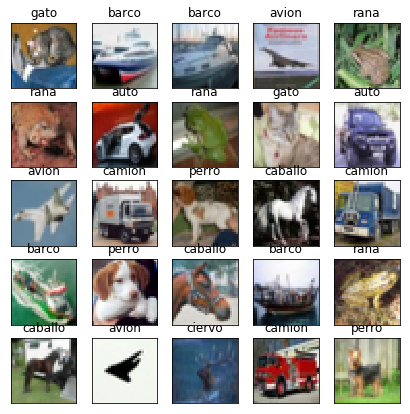

In [82]:
clases = ['avion','auto','pajaro','gato','ciervo',
          'perro','rana','caballo','barco','camion']
# dibujar imagenes
X= np.transpose(np.reshape(Xt,(-1,32,32,3), order='F'),
                        axes=(0,2,1,3)) #order batch,x,y,color
fig = plt.figure(figsize=(7,7))
for i in range(25):
    fig.add_subplot(5,5,(i+1),xticks=[], yticks=[])
    plt.title("{}".format(clases[Yt[i]]))
    plt.imshow(X[i])
plt.show()

In [4]:
Xtr=Xtr/255.0
Xt=Xt/255.0
Xv=Xv/255.0

A continuación se cambiará la dimensión matricial para entrenar la red:

In [5]:
num_classes=10

x_train = Xtr.reshape((Xtr.shape[0],32,32,3))

x_test= Xt.reshape((Xt.shape[0],32,32,3))

x_val= Xv.reshape((Xv.shape[0],32,32,3))

y_train = keras.utils.to_categorical(Ytr, num_classes)
y_test = keras.utils.to_categorical(Yt, num_classes)
y_val = keras.utils.to_categorical(Yv, num_classes)


#### b) Definición de CNN con arquitectura C × P × C × P × F × F .

In [7]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

Se observa que la red tiene un total de 2.142.514 parametros. La red en cuestión reduce la dimensión luego realizar la capa de pooling. Primero, la dimensión en de 32x32, luego 16x16 y antes de entra a FF es de 8x8.

#### c) Utilizando SGD se procederá a entrenar la red neuronal usando disminuidor de leanerng rate con el objetivo de que a medida de que avance el entrenamiento el learning rate disminuya para que encuentre un máximo rápido.

Para compilar la red neuronal se define como funnción de pérdida categorical_crossentropy ya que se esperan salidas excluyentes por cada categoría.

In [20]:
batch_size= 500

def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
hist_sgd= model.fit(x_train, y_train,batch_size=batch_size,epochs=25,
    validation_data=(x_val, y_val),shuffle=True,callbacks=[lrate], verbose= True)
model.save('entrenamientos/1c-neuronas.h5')

Train on 50000 samples, validate on 1003 samples
Epoch 1/25
50000/50000 [==============================] - 76s - loss: 0.0903 - acc: 0.0953 - val_loss: 0.0902 - val_acc: 0.0907
Epoch 2/25
50000/50000 [==============================] - 38s - loss: 0.0902 - acc: 0.0804 - val_loss: 0.0901 - val_acc: 0.0768
Epoch 3/25
50000/50000 [==============================] - 38s - loss: 0.0901 - acc: 0.0791 - val_loss: 0.0900 - val_acc: 0.0847
Epoch 4/25
50000/50000 [==============================] - 38s - loss: 0.0900 - acc: 0.0846 - val_loss: 0.0900 - val_acc: 0.0907
Epoch 5/25
50000/50000 [==============================] - 38s - loss: 0.0900 - acc: 0.0883 - val_loss: 0.0899 - val_acc: 0.0917
Epoch 6/25
50000/50000 [==============================] - 39s - loss: 0.0899 - acc: 0.0899 - val_loss: 0.0899 - val_acc: 0.0917
Epoch 7/25
50000/50000 [==============================] - 38s - loss: 0.0899 - acc: 0.0909 - val_loss: 0.0899 - val_acc: 0.0947
Epoch 8/25
50000/50000 [==============================]

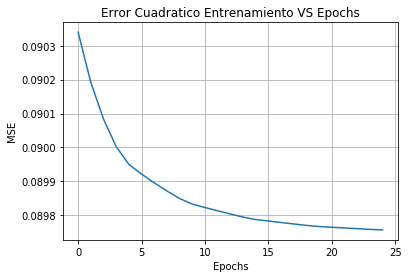

In [24]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Entrenamiento VS Epochs")
plt.plot(hist_sgd.epoch, hist_sgd.history['loss'])
plt.grid(True)

plt.show()

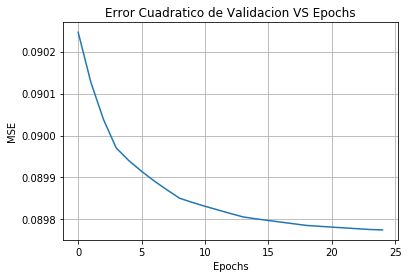

In [25]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error de Validacion VS Epochs")
plt.plot(hist_sgd.epoch, hist_sgd.history['val_loss'])
plt.grid(True)

plt.show()

A partir de los gráficos anteriores se observa que el error de entrenamiento y el error de evaluación son practicamente iguales despues de un entrenamiento con 25 iteraciones.
También se aprecia que el error final de entrenamiento y evaluación es de 0,0898.

In [27]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print ("\nLoss:",test[0], "Accuracy:",test[1])



10000/10000 [==============================] - 9s     

Loss: 0.0897604174912 Accuracy: 0.0960999999195


Al evaluar el modelo con los datos de test se llegó a que el error tiene magnitud 0.0897604174912 y el accuracy es 0.0960999999195, que es similar a los valores obtenidos en entrenamiento y validación, cuya magnitud es muy baja ya que tan solo alcanza el 10%.

#### d) Entrenamiento de CNN con rmsProp, durante 25 epochs.

In [8]:
batch_size= 500
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
hist_rmsprop = model.fit(x_train, y_train,batch_size=batch_size,epochs=25,
    validation_data=(x_val, y_val),shuffle=True, verbose= True)
model.save('entrenamientos/1d-neuronas.h5')

Train on 50000 samples, validate on 678 samples
Epoch 1/25
50000/50000 [==============================] - 125s - loss: 0.0818 - acc: 0.2946 - val_loss: 0.0687 - val_acc: 0.4558
Epoch 2/25
50000/50000 [==============================] - 41s - loss: 0.0697 - acc: 0.4485 - val_loss: 0.0618 - val_acc: 0.5457
Epoch 3/25
50000/50000 [==============================] - 39s - loss: 0.0628 - acc: 0.5155 - val_loss: 0.0557 - val_acc: 0.5811
Epoch 4/25
50000/50000 [==============================] - 40s - loss: 0.0583 - acc: 0.5574 - val_loss: 0.0526 - val_acc: 0.6003
Epoch 5/25
50000/50000 [==============================] - 39s - loss: 0.0544 - acc: 0.5900 - val_loss: 0.0513 - val_acc: 0.6150
Epoch 6/25
50000/50000 [==============================] - 39s - loss: 0.0512 - acc: 0.6193 - val_loss: 0.0468 - val_acc: 0.6785
Epoch 7/25
50000/50000 [==============================] - 41s - loss: 0.0483 - acc: 0.6442 - val_loss: 0.0422 - val_acc: 0.7021
Epoch 8/25
50000/50000 [==============================]

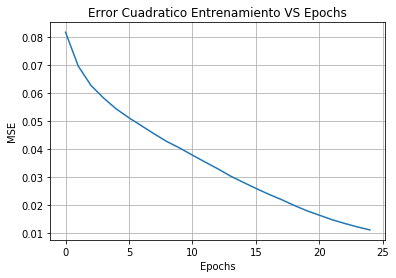

In [9]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Entrenamiento VS Epochs")
plt.plot(hist_rmsprop.epoch, hist_rmsprop.history['loss'])
plt.grid(True)

plt.show()

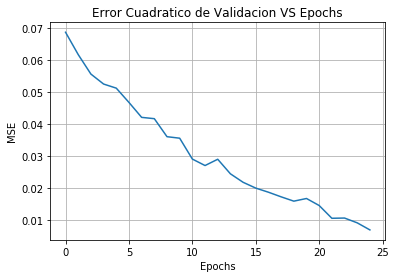

In [10]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error de Validacion VS Epochs")
plt.plot(hist_rmsprop.epoch, hist_rmsprop.history['val_loss'])
plt.grid(True)

plt.show()

Se observa en los gráficos anteriores que el error asociado al entrenamiento y evaluación de la red reuronal son muy iguales en magnitud, siendo mayor el error de entrenamiento, con magnitud 0.0111 y el error de evaluación es menor, con magnitd 0.0070. Cabe señalar que el accuracy de validación alcanza magnitud en el último epoch de 0.9572 sobre el conjunto de validación.

In [11]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print ("\nLoss:",test[0], "Accuracy:",test[1])

10000/10000 [==============================] - 15s    

Loss: 0.0488555239514 Accuracy: 0.670599994063


Al evaluar el conjunto de datos de test en el modelo entrenado se observa que el error aumenta significativamente en comparación al error de evaluación, por consiguiente, aumenta de 0.0070 a 0,0488.
Por otro lado, el accuracy de la evaluación en el conjunto de test es de 0,6706. Como se observa que en el conjunto de evaluación el accuracy es de orden 0,9, se entiende que en el periodo de entrenamiento y evaluación se sobre estima el performance de la red neuronal.

#### e) Experimentación con una arquitectura del tipo C × C × P × C × C × P × F × F .
A continuación se define la red nueronal:

In [89]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
__________

Ahora se procederá a entrenar el modelo definido anteriormente mendiante rmsprop:

In [90]:
batch_size=500
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
hist_rmsprop2 = model.fit(x_train, y_train,batch_size=batch_size,epochs=25,
    validation_data=(x_val, y_val),shuffle=True, verbose= True)
model.save('entrenamientos/1e-neuronas.h5')

Train on 50000 samples, validate on 550 samples
Epoch 1/25
50000/50000 [==============================] - 446s - loss: 0.0861 - acc: 0.2431 - val_loss: 0.0823 - val_acc: 0.2982
Epoch 2/25
50000/50000 [==============================] - 128s - loss: 0.0751 - acc: 0.3849 - val_loss: 0.0681 - val_acc: 0.4855
Epoch 3/25
50000/50000 [==============================] - 127s - loss: 0.0671 - acc: 0.4704 - val_loss: 0.0589 - val_acc: 0.5527
Epoch 4/25
50000/50000 [==============================] - 126s - loss: 0.0613 - acc: 0.5254 - val_loss: 0.0533 - val_acc: 0.6055
Epoch 5/25
50000/50000 [==============================] - 127s - loss: 0.0561 - acc: 0.5748 - val_loss: 0.0522 - val_acc: 0.6073
Epoch 6/25
50000/50000 [==============================] - 127s - loss: 0.0514 - acc: 0.6148 - val_loss: 0.0458 - val_acc: 0.6600
Epoch 7/25
50000/50000 [==============================] - 124s - loss: 0.0477 - acc: 0.6447 - val_loss: 0.0405 - val_acc: 0.7000
Epoch 8/25
50000/50000 [=========================

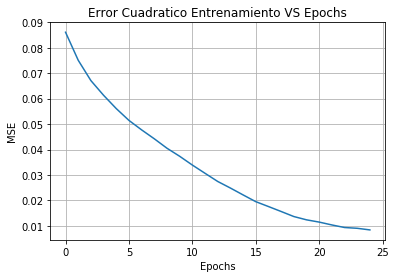

In [91]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Entrenamiento VS Epochs")
plt.plot(hist_rmsprop2.epoch, hist_rmsprop2.history['loss'])
plt.grid(True)

plt.show()

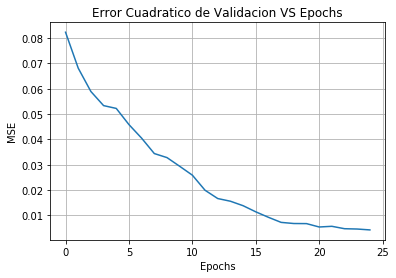

In [93]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error de Validacion VS Epochs")
plt.plot(hist_rmsprop2.epoch, hist_rmsprop2.history['val_loss'])
plt.grid(True)

plt.show()

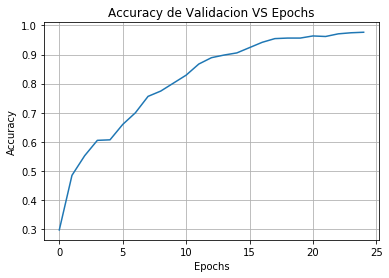

In [94]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy de Validacion VS Epochs")
plt.plot(hist_rmsprop2.epoch, hist_rmsprop2.history['val_acc'])
plt.grid(True)

plt.show()

In [95]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print ("\nLoss:",test[0], "Accuracy:",test[1])

10000/10000 [==============================] - 38s    

Loss: 0.0506091671064 Accuracy: 0.680500015616


A partir de los gráficos realizados, se puede entender que en el periodo de entrenamiento y evaluación, ya en el 5to epoch el modelo alcanza precisión cercana al 0,7 en entrenamiento y 0,7632 en el conjunto de evaluación. En el gráfico "Accuracy de Validacion VS Epochs" se obserba una pendiente positiva que rápidamente llega a un accuracy más alto que 0,75 y luego comienza a declinar su pendiente hasta un accuracy de orden 0.9.
Si se evalua el modelo en el conjunto de test, se observa que el accuracy es de 0.6805, cuya magnitud es mayor que en las redes definidas con anterioridad.

#### f) Cambio de capa de pooling por convolución, esperando el mismo efecto de reducción de dimensionalidad.

A continuación se definirá el modelo de la red.


In [6]:
model = Sequential()
model.add(Convolution2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))#cambio de pooling por convolucional
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, (3, 3), strides=(2, 2), padding='valid'))#cambio de pooling por convolucional
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

Se observa que en efecto se reduce la dimensionalidad, sin embargo no funciona de igual manera que la capa de pooling, ya que la domensionalidad no se disminuye a la mitad. Cuando se usa la capa de pooling la dimensión diminuye a la mitad (de 32 a 16), en cambio al usar una capa convolucional de 2x2, la dimensión disminuye de 32 a 15.

Ahora se procederá a entrenar la red con rmsprop:


In [8]:
batch_size= 50
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
hist_rmsprop3 = model.fit(x_train, y_train,batch_size=batch_size,epochs=25,
    validation_data=(x_val, y_val),shuffle=True, verbose= True)
model.save('entrenamientos/1f-neuronas.h5')

Train on 50000 samples, validate on 2952 samples
Epoch 1/25
50000/50000 [==============================] - 81s - loss: 0.0630 - acc: 0.5098 - val_loss: 0.0559 - val_acc: 0.5745
Epoch 2/25
50000/50000 [==============================] - 68s - loss: 0.0512 - acc: 0.6158 - val_loss: 0.0418 - val_acc: 0.6975
Epoch 3/25
50000/50000 [==============================] - 68s - loss: 0.0433 - acc: 0.6847 - val_loss: 0.0345 - val_acc: 0.7537
Epoch 4/25
50000/50000 [==============================] - 68s - loss: 0.0366 - acc: 0.7380 - val_loss: 0.0292 - val_acc: 0.7998
Epoch 5/25
50000/50000 [==============================] - 68s - loss: 0.0307 - acc: 0.7869 - val_loss: 0.0243 - val_acc: 0.8330
Epoch 6/25
50000/50000 [==============================] - 71s - loss: 0.0256 - acc: 0.8249 - val_loss: 0.0198 - val_acc: 0.8699
Epoch 7/25
50000/50000 [==============================] - 68s - loss: 0.0216 - acc: 0.8566 - val_loss: 0.0161 - val_acc: 0.8923
Epoch 8/25
50000/50000 [==============================]

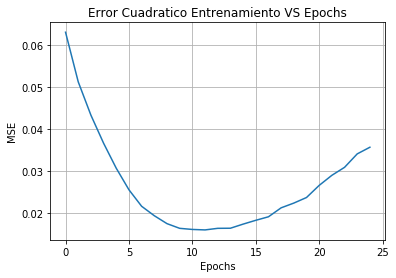

In [9]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Entrenamiento VS Epochs")
plt.plot(hist_rmsprop3.epoch, hist_rmsprop3.history['loss'])
plt.grid(True)

plt.show()

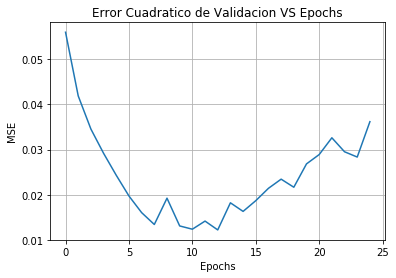

In [10]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error de Validacion VS Epochs")
plt.plot(hist_rmsprop3.epoch, hist_rmsprop3.history['val_loss'])
plt.grid(True)

plt.show()

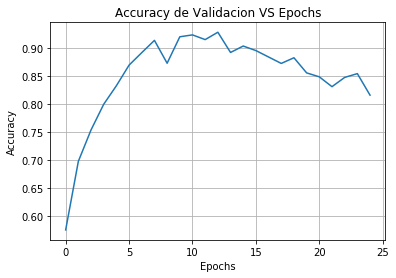

In [11]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy de Validacion VS Epochs")
plt.plot(hist_rmsprop3.epoch, hist_rmsprop3.history['val_acc'])
plt.grid(True)

plt.show()

In [26]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print ("\nLoss:",test[0], "Accuracy:",test[1])

10000/10000 [==============================] - 3s     

Loss: 0.0627585105598 Accuracy: 0.617000007629


Se observa en los gráficos anteriores un fenomeno muy particular, ya que el gráfico del error de entrenamiento alcanza un mínimo y luego vuelve a crecer. Este fenomeno puede confundirse con overfitting, sin embargo cuando se observa el accuracy del entrenamiento tambien tiene un comportamiento similar, se alcanza un maximo y luego disminuye. Esto tambien se puede evidenciar en el accuracy del conjunto de test resprensentado en el gráfico "Accuracy de Validacion VS Epochs", donde se visualiza que cerca del epoch 10 se alcanza un máximo.

Esta  singularidad se puede explicar considerando que la red neuronal halla encontrado un óptimo local y luego comenzó a salirse de él, por consecuencia, tempranamente encuentra un bajo error y accuracy muy alto y luego estos valores comienzan a crecer y decrecer respectivamente.

Por otro lado, no es muy conveniente utilizar este método ya que lo único que se gana es tiempo de entrenamiento, mientras que el error aumenta y el accuracy disminuye en relación a la versión con una capa de pooling.

#### g) Una forma interesante de regularizar modelos entrenados para visión artificial consiste en “aumentar” el número de ejemplos de entrenamiento usando transformaciones sencillas como: rotaciones, corrimientos y reflexiones, tanto horizontales como verticales. Explique porqué este procedimiento podrı́a ayudar a mejorar el modelo. Evalúe experimentalmente la conveniencia de incorporarlo.

A Continuación se definirá el método para aumentar el número de ejemplos:

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)

Ahora se procederá a entrenar la red neuronal con un batch de tamaño 500 y un optimizador RMSprop.

In [15]:
batch_size= 500
opt = rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
hist_datagen = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
    steps_per_epoch=x_train.shape[0]// batch_size,
    epochs=25,validation_data=(x_val, y_val))
model.save('entrenamientos/1g-neuronas.h5')

Epoch 1/25
100/100 [==============================] - 295s - loss: 0.0878 - acc: 0.1992 - val_loss: 0.0807 - val_acc: 0.3042
Epoch 2/25
100/100 [==============================] - 289s - loss: 0.0802 - acc: 0.3170 - val_loss: 0.0730 - val_acc: 0.4003
Epoch 3/25
100/100 [==============================] - 292s - loss: 0.0751 - acc: 0.3789 - val_loss: 0.0698 - val_acc: 0.4476
Epoch 4/25
100/100 [==============================] - 286s - loss: 0.0715 - acc: 0.4209 - val_loss: 0.0693 - val_acc: 0.4692
Epoch 5/25
100/100 [==============================] - 286s - loss: 0.0687 - acc: 0.4510 - val_loss: 0.0626 - val_acc: 0.5093
Epoch 6/25
100/100 [==============================] - 289s - loss: 0.0663 - acc: 0.4715 - val_loss: 0.0669 - val_acc: 0.4778
Epoch 7/25
100/100 [==============================] - 287s - loss: 0.0645 - acc: 0.4895 - val_loss: 0.0614 - val_acc: 0.5308
Epoch 8/25
100/100 [==============================] - 287s - loss: 0.0624 - acc: 0.5126 - val_loss: 0.0569 - val_acc: 0.5581


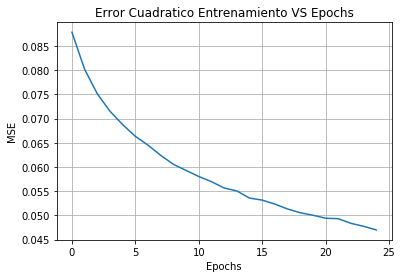

In [16]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error Entrenamiento VS Epochs")
plt.plot(hist_datagen.epoch, hist_datagen.history['loss'])
plt.grid(True)

plt.show()

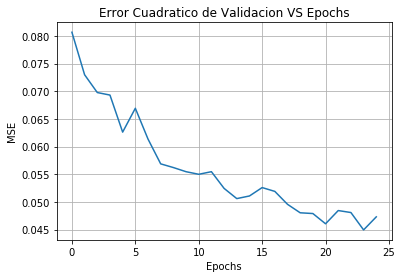

In [17]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Error de Validacion VS Epochs")
plt.plot(hist_datagen.epoch, hist_datagen.history['val_loss'])
plt.grid(True)

plt.show()

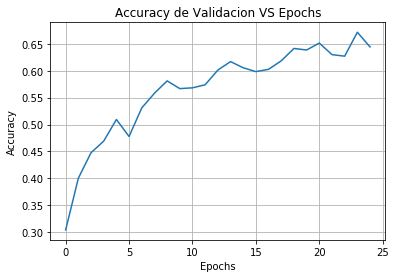

In [18]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy de Validacion VS Epochs")
plt.plot(hist_datagen.epoch, hist_datagen.history['val_acc'])
plt.grid(True)

plt.show()

In [19]:
test = model.evaluate(x_test, y_test,verbose=1, batch_size=batch_size)
print "\nLoss:",test[0], "Accuracy:",test[1]

10000/10000 [==============================] - 19s    

Loss: 0.0496083019301 Accuracy: 0.631100004911


Mediante los gráficos obtenidos del entrenamiento de la red neuronal anterior, se puede apreciar que el accuracy de entrenamiento no es muy alto y es congruente con el accuracy de validación y el obtenido al evaluar el conjunto de test. Por otro lado, el tiempo de ejecución de este entrenamiento es alto en relación a los entrenamientos anteriores.

Sobre el error obtenido sobre el conjunto de entrenamiento y de validación se aprecia que no hay presencia de overfitting que ambos decrecen en forma exponencial.

Este método puede ser conveniente para estimar sobre el conjunto de validación un accracy real de la red neuronal, ya que a diferencia de las otras redes neuronales entrenadas en este item, esta red no sobre estima el perfomance al evaluar el conjunto de test.

#### h) Elija una de las redes entrenadas en esta sección y determine los pares de objetos (por ejemplo “perros” con “gatos”) que la red tiende a confundir. Conjeture el motivo de tal confusión.

A continuación de definirá una función que extraiga todas las imágenes de una categoría a partir de un dataset.

In [96]:
def subcategory(x,y,categoria):
    seleccionados=[]
    subArray=[]
    for i in range(len(y)):
        if y[i] == categoria:
            seleccionados.append(i)
    for j in seleccionados:
        subArray.append(x[j])
    return np.array(subArray) 

avion = subcategory(x_test, Yt, 0)
auto = subcategory(x_test, Yt, 1)
pajaro = subcategory(x_test, Yt, 2)
gato = subcategory(x_test, Yt, 3)
ciervo = subcategory(x_test, Yt, 4)
perro = subcategory(x_test, Yt, 5)
rana = subcategory(x_test, Yt, 6)
caballo = subcategory(x_test, Yt, 7)
barco = subcategory(x_test, Yt, 8)
camion = subcategory(x_test, Yt, 9)    

En el siguiente apartado se procederá a caragar la red neuronal del apartado e) con una estructura C × C × P × C × C × P × F × F, con el que se predecirá las categorias del conjunto de test.

In [97]:
modelo= load_model('entrenamientos/1e-neuronas.h5')
print('Prediciendo por categorias:')
predAvion= modelo.predict(avion, verbose=1)
predAuto= modelo.predict(auto, verbose=1)
predPajaro= modelo.predict(pajaro, verbose=1)
predGato= modelo.predict(gato, verbose=1)
predCiervo= modelo.predict(ciervo, verbose=1)
predPerro= modelo.predict(perro, verbose=1)
predRana= modelo.predict(rana, verbose=1)
predCaballo= modelo.predict(caballo, verbose=1)
predBarco= modelo.predict(barco, verbose=1)
predCamion= modelo.predict(camion, verbose=1)

Prediciendo por categorias:
 992/1000 [============================>.] - ETA: 0s

La siguiente función tiene como objetivo obtener las dos predicciones mas recurrentes sobre un conjunto de datos predecidos.

In [98]:
def catDePrediccion(prediction):
    a= np.argmax(prediction, axis=1)
    unique, counts = np.unique(a, return_counts=True)
    result= dict(zip(unique, counts))
    orden=sorted(result.values())
    one= None
    two = None
    for key, value in result.items():
        if value == orden[-1]:
            one = key
        elif value == orden[-2]:
            two = key
    return one, two

Con lo anterior se procede a evaluar cada conjunto de imagenes, segmentado por categorias:

In [99]:
a, b = catDePrediccion(predAvion)
print("Para Avion la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predAuto)
print("Para Auto la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predPajaro)
print("Para Pajaro la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predGato)
print("Para Gato la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predCiervo)
print("Para Ciervo la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predPerro)
print("Para Perro la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predRana)
print("Para Rana la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predCaballo)
print("Para Caballo la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predBarco)
print("Para Barco la predicciones tienden a: ",clases[a]," y " ,clases[b])
a, b = catDePrediccion(predCamion)
print("Para Camion la predicciones tienden a: ",clases[a]," y " ,clases[b])

Para Avion la predicciones tienden a:  avion  y  camion
Para Auto la predicciones tienden a:  auto  y  camion
Para Pajaro la predicciones tienden a:  pajaro  y  gato
Para Gato la predicciones tienden a:  gato  y  perro
Para Ciervo la predicciones tienden a:  ciervo  y  pajaro
Para Perro la predicciones tienden a:  perro  y  gato
Para Rana la predicciones tienden a:  rana  y  gato
Para Caballo la predicciones tienden a:  caballo  y  gato
Para Barco la predicciones tienden a:  barco  y  avion
Para Camion la predicciones tienden a:  camion  y  auto


Ahora se ven las categorias mas recurrentes al predecir un conjunto de imágenes de la misma categoria. Existen conjeturas comunes, por ejemplo, la figura de un gato es similar a la de un perro, ambos son cuadrupedos, poseen cabellos en sus cuerpos; un auto es muy parecido a un camión, por echo de que son máquinas con ruedas y un ciervo es parecido a un caballo en cierta medida. 

Al igual que como los humanos somos capaces de reconocer características, la red neuronal es capaz de reconocer ciertas cualidades de las imágenes y estas son determinantes al momento de categorizar cada una de ellas, es por este motivo que se confunde al categorizar un gato con un perro, a un auto con un camión o un ciervo con un caballo. Sin embargo, existen pares que para el ser humano no tienen mucha relación, como lo es una rana con un ciervo o un pajaro con un ciervo, que la red neuronal los reconoce como similares.